# Assignment 2: Computational methods in Finance
## UNI: cl4249
## Charles Laferte

Use explicit-implicit finite difference scheme covered during the lecture to solve the PIDE.
Calculate UOC option premium in this framework for the following parameters: spot price, S0 = $1900; strike price K = 2000;
upper barrier B = 2200, risk-free interest rate, r = 0.25%; dividend rate, q = 1.5%; maturity, T = 0.5 year; σ = 25%, ν = 0.31,
θ = −0.25, and Y = 0.4.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import bs as bs
from scipy import integrate

In [21]:
def tridiagSolver(l, d, u, f):
    
    ''' 
    Tridiagonal solver 
    '''
    
    n = len(f)
    v = np.zeros(n)
    y = np.zeros(n)
    w = d[0]
    y[0] = 1.0 * f[0] / w
    
    for i in range(1, n):
        v[i-1] = 1. * u[i-1] / w
        w = d[i] - l[i] * v[i-1]
        y[i] = 1. * (f[i] - l[i] * y[i-1]) / w
    
    for j in range(n-2, -1, -1):
        y[j] = y[j] - v[j] * y[j+1]
    
    return y

In [175]:
# Parameters for the computations
N = 100
M = 500

# Parameters of the UOC option call
T = 0.5
K = 2000
S0 = 1900
B = 2200
sigma = 0.25
r = 0.0025
q = 0.015

theta = -0.25
Y = 0.4
v = 0.31

alpha = 0.5#0.5 #0.5 * (sig ** 2) * dT / (dS ** 2)???????????

In [36]:
lbda_p = ((theta/sigma**2)**2+2/(sigma**2*v))**0.5-theta/(sigma**2)
lbda_n = ((theta/sigma**2)**2+2/(sigma**2*v))**0.5+theta/(sigma**2)


In [182]:
np.exp(10)

22026.465794806718

In [37]:
def k(y): 
    if y>0 : 
        return(np.exp(-y*lbda_p)/(v*y**(1+Y)))
    else: # est ce qu'il faut pas tej le terme en 0 cf la vrai def de k
        return(np.exp(-np.abs(y)*lbda_n)/(v*np.abs(y)**(1+Y))) # le premier abs ne sert à rien sans doute si on chge le signe
               
               

In [43]:
def g1(ksi, alpha, dx):
    g1 = integrate.quad(lambda y: np.exp(-y)/(y**alpha), dx, np.inf)[0]#, -np.inf, -dx)[0]
    return g1

def g2(ksi, alpha, dx):
    g2 = integrate.quad(lambda y: np.exp(-y)/(y**(alpha+1)), dx, np.inf)[0]#, -np.inf, -dx)[0]
    return g2

In [96]:
def precomp_g(lbda_p, lbda_n, dx, N):
    
    g1n = np.zeros(N)
    g1p = np.zeros(N)
    g2n = np.zeros(N)
    g2p = np.zeros(N)
    
    g2n_p1 = np.zeros(N)
    g2p_m1 = np.zeros(N)
    
    for i in range(N):
        g1n[i] = g1(i*dx*lbda_n, alpha, dx)
        g1p[i] = g1(i*dx*lbda_p, alpha, dx)
        g2n[i] = g2(i*dx*lbda_n, alpha, dx)
        g2p[i] = g2(i*dx*lbda_p, alpha, dx)
    
        g2n_p1[i] = g2(i*dx*(lbda_n+1), alpha, dx)
        g2p_m1[i] = g2(i*dx*(lbda_p-1), alpha, dx)
    
    return g1n, g1p, g2n, g2p, g2n_p1, g2p_m1
    

In [121]:
def omega_(Y, dx, g1n, g1p, g2n, g2p, g2n_p1, g2p_m1):
    #om = integrate.quad(lambda y: (1-np.exp(y))*k(y), -np.inf, -dx)[0]
    #om += integrate.quad(lambda y: (1-np.exp(y))*k(y), dx, np.inf)[0]
    om = 0
    om = lbda_p**Y*g2p[1]-(lbda_p-1)**Y*g2p_m1[1]/v
    print(lbda_p)
    print(g2p[1])
    print(v)
    print(g2p_m1[1])
    print('y', Y)
    print('om', om)
    om+= lbda_n**Y*g2n[1]-(lbda_n-1)**Y*g2n_p1[1]/v
    print('om', om)
    return om
   
def sigma_2(Y,dx,g1n, g1p, g2n, g2p, g2n_p1, g2p_m1):
    #sig = integrate.quad(lambda y: y**2*k(y), -np.inf, -dx)[0]
    #sig += integrate.quad(lambda y: y**2*k(y), dx, np.inf)[0] 
    
    sig = (-(lbda_p*dx)**(1-Y)*np.exp(-lbda_p*dx)-(1-Y)*(g1p[0]-g1p[1]))*lbda_p**(Y-2)/v
    sig+= (-(lbda_n*dx)**(1-Y)*np.exp(-lbda_n*dx)-(1-Y)*(g1n[0]-g1n[1]))*lbda_n**(Y-2)/v
    
    return sig

In [176]:
def pricing_uoc(S0, K, B, r, q, T, sigma, v, theta, Y, N, M):
    print('Y1',Y)
    
    x0 = np.log(S0)
    xN = np.log(B)
    dx = (xN - x0) / N
    dt = T / M
    
    x = np.linspace(x0, xN, N+1)
    t = np.linspace(0, T, M+1)
    
    lbda_p = ((theta/sigma**2)**2+2/(sigma**2*v))**0.5-theta/(sigma**2)
    lbda_n = ((theta/sigma**2)**2+2/(sigma**2*v))**0.5+theta/(sigma**2)
    print('Y2',Y)
    # Pre-computations of g1 and g2
    g1n, g1p, g2n, g2p, g2n_p1, g2p_m1 = precomp_g(lbda_p, lbda_n, dx, N+1)
    #print(g1n, g1p, g2n, g2p, g2n_p1, g2p_m1)
    print('Y3',Y)
    
    # Sigma and omega
    sigma2 = sigma_2(Y,dx,g1n, g1p, g2n, g2p, g2n_p1, g2p_m1)
    omega = omega_(Y,dx, g1n, g1p, g2n, g2p, g2n_p1, g2p_m1)
    
    
    # Compute Bl and Bu
    a = sigma2*dt/(2*dx**2) # ah en fait non sigma est une fonction
    b = (r-q + omega - 0.5*sigma2)*dt/(2*dx)
    Bu = a+b
    Bl = a-b
    
    
    ''' Indices:
        i between 0 and N for the discretisation of x-direction
        j between 0 and M for the discretisation of tau-direction (where tau=T-t)
    '''
    
    
    # Compute the R matrix :
    R = np.zeros((N+1,M+1))
    l = np.zeros((N+1,M+1))
    d = np.zeros((N+1,M+1))
    u = np.zeros((N+1,M+1))
    w = np.zeros((N+1,M+1))
    
    for i in range(N):
        for j in range(M):
            #corriger les indices
            #print(i,j)
            l[i,j+1] = -Bl
            u[i,j+1] = -Bu
            d[i,j+1] = 1+r*dt+Bl+Bu+dt*(lbda_n**Y*g2n[i]+lbda_p**Y*g2p[N-i])/v
            
    
    ''' Constraints:
    w(x0, τ ) = 0 ∀τ,
    w(xN , τ ) = w(B, τ ) = 0 ∀τ. 
    '''
    for i in range(N+1):
        w[i,M] = max(np.exp(x[i])-K,0)
        print (w[i,M])
    
    
    print('final computation')
    for j in range(M-1):
        for i in range(N-2):
            #print(i+1)
            R[i,j] = sum([lbda_n**Y*(w[i-k,j]-w[i,j]-k*(w[i-k-1,j]-w[i-k,j]))*(g2n[k]-g2n[k+1]) for k in range(i)])
            R[i,j] += sum([(w[i-k-1,j]-w[i-k,j])*(g1n[k]-g1n[k+1])/(lbda_n**(1-Y)*dx) for k in range(i)])
            R[i,j] += sum([lbda_p**Y*(w[i+k,j]-w[i,j]-k*(w[i+k+1,j]-w[i+k,j]))*(g2p[k]-g2p[k+1]) for k in range(N-i)])
            R[i,j] += sum([(w[i+k+1,j]-w[i+k,j])*(g1p[k]-g1p[k+1])/(lbda_p**(1-Y)*dx) for k in range(N-i)])
            R[i,j] += K * lbda_n**Y *g2n[i] - np.exp(x[i])* (lbda_n+1)**Y * g2n[i]     
            #print(R[i,j])             
            w[i+1,j+1] = w[i,j] + dt*R[i,j]/v - d[i,j+1]*w[i,j+1] - l[i,j+1]*w[i-1,j+1]
            #print(w[i+1,j+1])
            w[i+1,j+1] = w[i+1,j+1]/u[i,j+1]
            #print(w[i+1,j+1])
            
        print('j',j,'w',w[0,j])
                          
    return x, t, w
    

In [177]:
x, t , w = pricing_uoc(S0, K, B, r, q, T, sigma, v, theta, 0.4, N, M)

Y1 0.4
Y2 0.4
Y3 0.4
14.919057031246467
48.766202089437726
0.31
48.766202089437726
y 0.4
om -307.27304633875553
om -521.9325101292325
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.035843480396806626
2.9701158591035437
5.908693137857199
8.851581632415218
11.798787667807119
14.75031757834131
17.706177707614415
20.66637440853674
23.630914043331813
26.599802983562768
29.57304761014052
32.55065431333196
35.53262949278451
38.51897955753475
41.50971092601685
44.50483002608644
47.504343295029685
50.508257179571956
53.51657813590327
56.52931262967877
59.54646713604461
62.568048139646635
65.5940621346399
68.62451562471097
71.65941512308882
74.6987671525535
77.74257824545975
80.79085494374112
83.84360379893269
86.90083137218244
89.96254423425762
93.0287489655725
96.09945215619382
99.17466040585259
102.25438032396914
105.33861852965356
108.4273816517316
111.52067632875469
114.61850920900861
117.72088695

cf precalculate some vectors for speeding it up


In [151]:
w

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.01945115e-02, -1.01945115e-02, ...,
        -1.01945115e-02, -1.01945115e-02,  0.00000000e+00],
       [ 0.00000000e+00, -1.60285833e-02, -1.60398397e-02, ...,
        -1.60398397e-02, -1.60398397e-02,  0.00000000e+00],
       ...,
       [ 1.93558895e+02,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.96777087e+02,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.00000000e+02,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [86]:
w

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.01945115e-02, -1.01945115e-02, ...,
        -1.01945115e-02, -1.01945115e-02,  0.00000000e+00],
       [ 0.00000000e+00, -1.60285833e-02, -1.60398397e-02, ...,
        -1.60398397e-02, -1.60398397e-02,  0.00000000e+00],
       ...,
       [ 0.00000000e+00, -1.34292649e+01, -1.36656372e+01, ...,
        -1.36688648e+01, -1.36688648e+01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [78]:
np.shape(w)

(101, 101)

In [128]:
x0 = np.log(S0)
xN = np.log(B)
dx = (xN - x0) / N
dt = T / M

101
(101, 501)


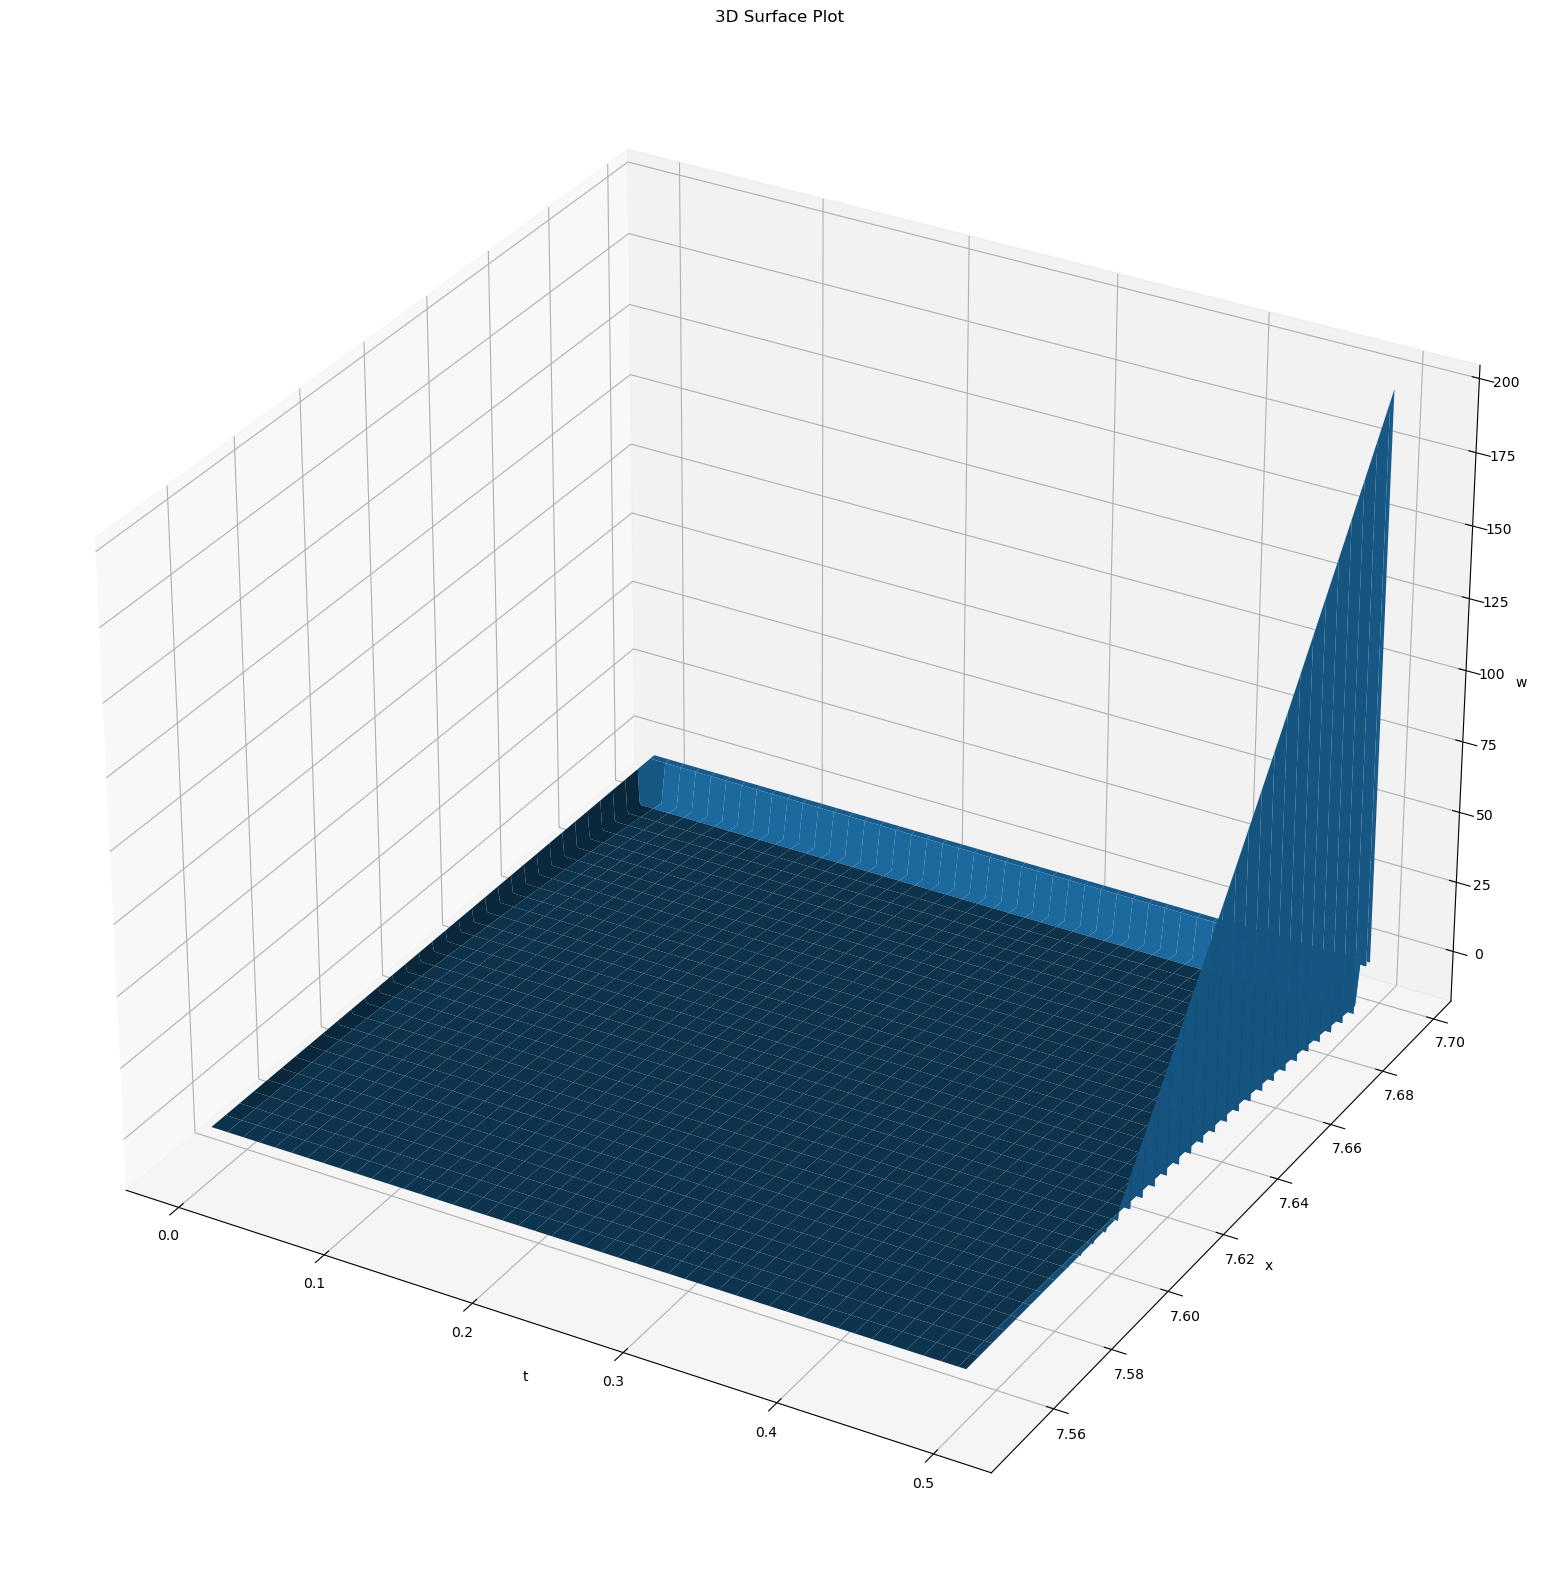

In [183]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example values for x and y axes
#x = np.linspace(-5, 5, 100)
#y = np.linspace(-5, 5, 100)
x = np.linspace(x0, xN, N+1)
t = np.linspace(0, T, M+1)
X, Y = np.meshgrid(t,x)
print(len(x))
# Example matrix of values for the vertical axis
Z = w
print(np.shape(Z))
# Create 3D figure
fig = plt.figure(figsize = (40,20))
ax = fig.add_subplot(111, projection='3d')

# Plot surface with X, Y, and Z values
ax.plot_surface(X, Y, Z)

# Add axis labels and title
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('w')
ax.set_title('3D Surface Plot')

# Show the plot
plt.show()


test 2

In [43]:
import numpy as np
from scipy.stats import norm

def UOC_option_premium(S0, K, B, r, q, T, sigma, nu, theta, Y, N, M):
    # Discretize the space and time domains
    x0 = np.log(S0)
    xN = np.log(B)
    dx = (xN - x0) / N
    dt = T / M
    x = np.linspace(x0, xN, N+1)
    t = np.linspace(0, T, M+1)

    # Initialize the option value at the final time step
    w = np.maximum(np.exp(x) - K, 0)

    # Compute the coefficients for the implicit method
    lp = (theta**2 / (2*sigma**2)) + (2*nu/sigma**2)
    ln = (theta**2 / (2*sigma**2)) - (2*nu/sigma**2)
    alpha = np.zeros(N+1)
    beta = np.zeros(N+1)
    gamma = np.zeros(N+1)
    for j in range(1, N):
        alpha[j] = dt * (lp * (x[j+1] - x[j]) / dx**2 - (r-q) / dx)
        beta[j] = 1 - dt * (r + lp * 2*(x[j+1] - x[j-1]) / dx**2)
        gamma[j] = dt * (lp * (x[j] - x[j-1]) / dx**2 + (r-q) / dx)

    # Solve the PIDE iteratively
    for i in range(M-1, -1, -1):
        # Compute the option value at time ti
        for j in range(1, N):
            if x[j] < np.log(B):
                w[j] = beta[j] * w[j] + alpha[j] * w[j-1] + gamma[j] * w[j+1]
                y = np.log(B) - x[j]
                k = np.exp(-nu*y) * norm.cdf(ln*y + nu*y + sigma*np.sqrt(dt), loc=0, scale=1) - np.exp(ln*y) * norm.cdf(ln*y + sigma*np.sqrt(dt), loc=0, scale=1)
                #print(k)
                w[j] -= dt * k * w[j-1]
                #print(w[j])
            else:
                w[j] = 0
                #print('nope')
        print(w)
    # Return the option value at the initial time step
    return w[0]


In [44]:
S0 = 1900
K = 2000
B = 2200
r = 0.0025
q = 0.015
T = 0.5
sigma = 0.25
nu = 0.31
theta = -0.25
Y = 0.4
N = 200
M = 100

premium = UOC_option_premium(S0, K, B, r, q, T, sigma, nu, theta, Y, N, M)
#print(f"The UOC option premium is: {premium[0]:.4f}")

print(premium)


[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.000000

[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.000000

[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 1.16528390e+017 8.315668

[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 4.16906069e+022 3.81522265e+025 1.87918404e+028
 6.61260170e+030 1.862390

/var/folders/pr/693wddvj41v3lzy50wnq69fc0000gn/T/ipykernel_90945/1470620519.py:32: RuntimeWarning: overflow encountered in double_scalars
  w[j] = beta[j] * w[j] + alpha[j] * w[j-1] + gamma[j] * w[j+1]
/var/folders/pr/693wddvj41v3lzy50wnq69fc0000gn/T/ipykernel_90945/1470620519.py:32: RuntimeWarning: invalid value encountered in double_scalars
  w[j] = beta[j] * w[j] + alpha[j] * w[j-1] + gamma[j] * w[j+1]
/var/folders/pr/693wddvj41v3lzy50wnq69fc0000gn/T/ipykernel_90945/1470620519.py:36: RuntimeWarning: invalid value encountered in double_scalars
  w[j] -= dt * k * w[j-1]


[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 7.51707709e+031 9.40369893e+034 6.21744089e+037 2.88886376e+040
 1.05849444e+043 3.25465350e+045 8.72904954e+047 2.09627311e+050
 4.59313189e+052 9.312314

[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 2.68940047e+037 3.90632309e+040 2.97735174e+043
 1.58432250e+046 6.60833959e+048 2.30038771e+051 6.94950954e+053
 1.87109869e+056 4.57660981e+058 1.03166987e+061 2.16734904e+063
 4.28111311e+065 8.008400

[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 6.83068259e+044 1.17567586e+048 1.05432590e+051
 6.55788744e+053 3.17799965e+056 1.27809726e+059 4.43766390e+061
 1.36656058e+064 3.80579747e+066 9.72700530e+068 2.30774654e+071
 5.12893795e+073 1.07576029e+076 2.14247183e+078 4.07249342e+080
 7.42075664e+082 1.301085

[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 8.74333359e+055
 1.85724996e+059 2.04029038e+062 1.54382086e+065 9.04238085e+067
 4.36868227e+070 1.81186456e+073 6.62923237e+075 2.18252580e+078
 6.56318852e+080 1.82391374e+083 4.72812408e+085 1.15208565e+088
 2.65549205e+090 5.82085779e+092 1.21894657e+095 2.44814239e+097
 4.73170586e+099 8.82710517e+101 1.59358551e+104 2.79059637e+106
 4.74987316e+108 7.872917

[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 3.12812083e+061 7.27507128e+064 8.72576756e+067 7.18969245e+070
 4.57427068e+073 2.39497325e+076 1.07406174e+079 4.24047444e+081
 1.50349092e+084 4.85996897e+086 1.44919955e+089 4.02424299e+091
 1.04870419e+094 2.58119270e+096 6.03301515e+098 1.34523259e+101
 2.87299261e+103 5.89719357e+105 1.16692700e+108 2.23196943e+110
 4.13625765e+112 7.44251486e+114 1.30271100e+117 2.22195226e+119
 3.69871698e+121 6.017375

[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 7.94496794e+068 2.06122729e+072 2.74937289e+075 2.51198516e+078
 1.76729562e+081 1.02055343e+084 5.03544459e+086 2.18210955e+089
 8.47318695e+091 2.99323233e+094 9.73456561e+096 2.94248980e+099
 8.33153035e+101 2.22416507e+104 5.62888679e+106 1.35682701e+109
 3.12771357e+111 6.91921254e+113 1.47350878e+116 3.02899061e+118
 6.02481057e+120 1.16205969e+123 2.17769282e+125 3.97199787e+127
 7.06244462e+129 1.22591891e+132 2.08018147e+134 3.45459634e+136
 5.62122530e+138 8.971089

[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 2.01790529e+076 5.77738713e+079 8.48281313e+082 8.51105573e+085
 6.56065078e+088 4.14194418e+091 2.22967381e+094 1.05210979e+097
 4.44014552e+099 1.70168031e+102 5.99371967e+104 1.95895318e+107
 5.98797255e+109 1.72310827e+112 4.69385219e+114 1.21615291e+117
 3.00930461e+119 7.13693696e+121 1.62736550e+124 3.57757022e+126
 7.60134785e+128 1.56440493e+131 3.12481270e+133 6.06864587e+135
 1.14777548e+138 2.11719353e+140 3.81406652e+142 6.71856749e+144
 1.15856132e+147 1.95780678e+149 3.24525706e+151 5.28136112e+153
 8.44541977e+155 1.328040

[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 7.21950215e+081 2.21246854e+085 3.47155827e+088
 3.71654937e+091 3.05238490e+094 2.05033801e+097 1.17276607e+100
 5.87253017e+102 2.62678494e+105 1.06576043e+108 3.96957824e+110
 1.37047115e+113 4.42052172e+115 1.34097749e+118 3.84713259e+120
 1.04880269e+123 2.72824398e+125 6.79622440e+127 1.62637285e+130
 3.74934187e+132 8.34744852e+134 1.79880505e+137 3.75938455e+139
 7.63375984e+141 1.50856221e+144 2.90563575e+146 5.46218776e+148
 1.00342401e+151 1.80341578e+153 3.17440880e+155 5.47788205e+157
 9.27558386e+159 1.54246862e+162 2.52104277e+164 4.05277141e+166
 6.41254315e+168 9.992956

[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 1.83364762e+089 6.11201140e+092 1.04117562e+096
 1.20798586e+099 1.07336443e+102 7.78779246e+104 4.80403194e+107
 2.59046454e+110 1.24598607e+113 5.42859468e+115 2.16838953e+118
 8.01817721e+120 2.76668884e+123 8.96761421e+125 2.74578891e+128
 7.98034383e+130 2.21079524e+133 5.85903077e+135 1.49018768e+138
 3.64773050e+140 8.61520695e+142 1.96766171e+145 4.35471430e+147
 9.35603239e+149 1.95466115e+152 3.97703749e+154 7.89151965e+156
 1.52907519e+159 2.89650685e+161 5.36993057e+163 9.75319272e+165
 1.73705253e+168 3.03628534e+170 5.21297221e+172 8.79767244e+174
 1.46047740e+177 2.38645000e+179 3.84068225e+181 6.09136833e+183
 9.52596159e+185 1.469649

[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 4.65719592e+096 1.67749117e+100 3.08303492e+103
 3.85331245e+106 3.68301912e+109 2.87043254e+112 1.89946248e+115
 1.09731790e+118 5.64751376e+120 2.62966331e+123 1.12128724e+126
 4.42117983e+128 1.62494561e+131 5.60428832e+133 1.82406376e+136
 5.62992349e+138 1.65474033e+141 4.64850190e+143 1.25213737e+146
 3.24330072e+148 8.09887342e+150 1.95413904e+153 4.56533648e+155
 1.03462914e+158 2.27837643e+160 4.88275347e+162 1.01980130e+165
 2.07845432e+167 4.13864065e+169 8.06019796e+171 1.53690611e+174
 2.87192809e+176 5.26388695e+178 9.47114450e+180 1.67414795e+183
 2.90932179e+185 4.97379345e+187 8.37057743e+189 1.38756076e+192
 2.26683391e+194 3.65163048e+196 5.80321868e+198 9.10269103e+200
 1.40988037e+203 2.157193

[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 8.39721542e+105 3.30664291e+109 6.63268312e+112 9.03284580e+115
 9.39283008e+118 7.95224527e+121 5.70814159e+124 3.57200715e+127
 1.98869688e+130 1.00041160e+133 4.60275398e+135 1.95584580e+138
 7.73786848e+140 2.86943271e+143 1.00307005e+146 3.32159683e+148
 1.04635522e+151 3.14725836e+153 9.06816848e+155 2.51011433e+158
 6.69224481e+160 1.72249157e+163 4.28897150e+165 1.03509074e+168
 2.42536472e+170 5.52622088e+172 1.22617928e+175 2.65292951e+177
 5.60363707e+179 1.15684014e+182 2.33661092e+184 4.62197485e+186
 8.96161410e+188 1.70461165e+191 3.18335032e+193 5.84091251e+195
 1.05368784e+198 1.87006989e+200 3.26724219e+202 5.62250951e+204
 9.53538360e+206 1.59450547e+209 2.63028334e+211 4.28218524e+213
 6.88338726e+215 1.09292582e+218 1.71474642e+220 2.65944240e+222
 4.07864340e+224 6.187584

[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 2.13276951e+113 8.97142248e+116 1.92010431e+120 2.78699452e+123
 3.08542897e+126 2.77820558e+129 2.11879199e+132 1.40735292e+135
 8.30899519e+137 4.42846505e+140 2.15677496e+143 9.69313468e+145
 4.05261157e+148 1.58688707e+151 5.85302427e+153 2.04346754e+156
 6.78193931e+158 2.14759466e+161 6.51005382e+163 1.89457500e+166
 5.30712847e+168 1.43429397e+171 3.74764668e+173 9.48519919e+175
 2.32944536e+178 5.55984278e+180 1.29153040e+183 2.92385840e+185
 6.45877169e+187 1.39372625e+190 2.94099961e+192 6.07471584e+194
 1.22931961e+197 2.43937942e+199 4.75021701e+201 9.08424990e+203
 1.70729377e+206 3.15540257e+208 5.73846419e+210 1.02750186e+213
 1.81239601e+215 3.15087766e+217 5.40169781e+219 9.13588191e+221
 1.52504577e+224 2.51367196e+226 4.09260443e+228 6.58445967e+230
 1.04719040e+233 1.64689131e+235 2.56200392e+237 3.94371563e+239
 6.00857816e+241 9.063623

[0.00000000e+000 0.00000000e+000 2.72996367e+124 1.25837337e+128
 2.94686528e+131 4.67339677e+134 5.64504954e+137 5.53842871e+140
 4.59635530e+143 3.31804547e+146 2.12642395e+149 1.22874233e+152
 6.48064721e+154 3.15063594e+157 1.42337057e+160 6.01617061e+162
 2.39276788e+165 8.99914954e+167 3.21425478e+170 1.09436431e+173
 3.56351676e+175 1.11301878e+178 3.34324822e+180 9.68048275e+182
 2.70774676e+185 7.33054158e+187 1.92415712e+190 4.90473283e+192
 1.21589674e+195 2.93541589e+197 6.90993373e+199 1.58784677e+202
 3.56563281e+204 7.83227931e+206 1.68447266e+209 3.55007940e+211
 7.33770569e+213 1.48853276e+216 2.96578742e+218 5.80756855e+220
 1.11839100e+223 2.11931109e+225 3.95402952e+227 7.26705493e+229
 1.31633759e+232 2.35110519e+234 4.14255120e+236 7.20344249e+238
 1.23670157e+241 2.09705626e+243 3.51346319e+245 5.81826210e+247
 9.52640742e+249 1.54270169e+252 2.47163605e+254 3.91889774e+256
 6.15094535e+258 9.55949443e+260 1.47148180e+263 2.24392865e+265
 3.39078585e+267 5.078410

[0.00000000e+000 1.26329966e+147 1.39921529e+150 1.24423534e+153
 9.58264432e+155 6.54430004e+158 4.02624822e+161 2.25902517e+164
 1.16737806e+167 5.60143462e+169 2.51267323e+172 1.05980617e+175
 4.22397404e+177 1.59766602e+180 5.75643219e+182 1.98227271e+185
 6.54326938e+187 2.07582228e+190 6.34418779e+192 1.87188515e+195
 5.34244727e+197 1.47749024e+200 3.96581094e+202 1.03467544e+205
 2.62743210e+207 6.50217983e+209 1.56996786e+212 3.70249578e+214
 8.53700050e+216 1.92631915e+219 4.25737420e+221 9.22359319e+223
 1.96035660e+226 4.09032923e+228 8.38422200e+230 1.68936944e+233
 3.34814489e+235 6.53051683e+237 1.25425889e+240 2.37324977e+242
 4.42614051e+244 8.14011794e+246 1.47689064e+249 2.64458372e+251
 4.67550224e+253 8.16439115e+255 1.40863686e+258 2.40216099e+260
 4.05018182e+262 6.75385334e+264 1.11419952e+267 1.81899966e+269
 2.93954085e+271 4.70346247e+273 7.45343809e+275 1.17004225e+278
 1.81992472e+280 2.80549476e+282 4.28709545e+284 6.49537923e+286
 9.75933543e+288 1.454433

[0.00000000e+000 1.11835834e+171 7.43938847e+173 4.12805097e+176
 2.10057331e+179 9.96959248e+181 4.44503600e+184 1.87144895e+187
 7.47260549e+189 2.84052870e+192 1.03135022e+195 3.58738534e+197
 1.19856975e+200 3.85562048e+202 1.19674956e+205 3.59117205e+207
 1.04367121e+210 2.94232346e+212 8.05866123e+214 2.14721877e+217
 5.57288392e+219 1.41053077e+222 3.48542652e+224 8.41664657e+226
 1.98811397e+229 4.59774396e+231 1.04185531e+234 2.31507287e+236
 5.04814329e+238 1.08094826e+241 2.27438354e+243 4.70513034e+245
 9.57586113e+247 1.91830605e+250 3.78455717e+252 7.35666680e+254
 1.40966847e+257 2.66387514e+259 4.96653561e+261 9.13922237e+263
 1.66052740e+266 2.98003605e+268 5.28428378e+270 9.26155103e+272
 1.60491446e+275 2.75056782e+277 4.66360051e+279 7.82473872e+281
 1.29952299e+284 2.13685561e+286 3.47977012e+288 5.61323265e+290
 8.97142970e+292 1.42099222e+295 2.23097621e+297 3.47264030e+299
 5.36008317e+301 8.20563774e+303 1.24612491e+306             inf
             nan         

[0.00000000e+000 3.84807361e+189 2.08031874e+192 9.35246656e+194
 3.90864911e+197 1.54902084e+200 5.85720402e+202 2.12052821e+205
 7.37082668e+207 2.46576895e+210 7.95592791e+212 2.48074249e+215
 7.48857651e+217 2.19205674e+220 6.23145137e+222 1.72270119e+225
 4.63731512e+227 1.21694463e+230 3.11671802e+232 7.79809610e+234
 1.90790209e+237 4.56861997e+239 1.07160787e+242 2.46403422e+244
 5.55821301e+246 1.23083588e+249 2.67746205e+251 5.72493548e+253
 1.20390790e+256 2.49131793e+258 5.07578957e+260 1.01866273e+263
 2.01471031e+265 3.92864908e+267 7.55624494e+269 1.43408870e+272
 2.68670581e+274 4.97047201e+276 9.08365766e+278 1.64041976e+281
 2.92832691e+283 5.16877673e+285 9.02375708e+287 1.55862251e+290
 2.66419491e+292 4.50791221e+294 7.55227513e+296 1.25307588e+299
 2.05956028e+301 3.35402140e+303 5.41307929e+305 8.65964051e+307
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan         

[0.00000000e+000 2.16300716e+212 9.95060729e+214 3.76594766e+217
 1.33149286e+220 4.50920592e+222 1.47285724e+225 4.65366607e+227
 1.42506706e+230 4.23608254e+232 1.22403065e+235 3.44252499e+237
 9.43483847e+239 2.52256763e+242 6.58638814e+244 1.68098246e+247
 4.19738185e+249 1.02625820e+252 2.45888726e+254 5.77756500e+256
 1.33222302e+259 3.01661058e+261 6.71181925e+263 1.46822883e+266
 3.15951195e+268 6.69185839e+270 1.39569354e+273 2.86784235e+275
 5.80814707e+277 1.15990637e+280 2.28501146e+282 4.44224910e+284
 8.52565601e+286 1.61591012e+289 3.02564861e+291 5.59851362e+293
 1.02403564e+296 1.85214512e+298 3.31342231e+300 5.86461718e+302
 1.02725482e+305 1.78115801e+307             inf             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan         

[0.00000000e+000 5.09964325e+243 2.04428926e+246 6.63681214e+248
 2.01030319e+251 5.86419830e+253 1.66257729e+256 4.59642365e+258
 1.24117426e+261 3.27717284e+263 8.46864403e+265 2.14352896e+268
 5.31829434e+270 1.29434119e+273 3.09204960e+275 7.25499519e+277
 1.67292980e+280 3.79325015e+282 8.46192322e+284 1.85810157e+287
 4.01809928e+289 8.56092454e+291 1.79786873e+294 3.72316511e+296
 7.60597834e+298 1.53338107e+301 3.05178447e+303 5.99813316e+305
 1.16460912e+308             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan         

[0.00000000e+000 2.95147707e+261 1.12172496e+264 3.42553132e+266
 9.73786547e+268 2.66828910e+271 7.12245623e+273 1.85910469e+276
 4.75332480e+278 1.19166475e+281 2.93162679e+283 7.08190517e+285
 1.68090140e+288 3.92221842e+290 9.00225961e+292 2.03339689e+295
 4.52223592e+297 9.90704363e+299 2.13887107e+302 4.55256160e+304
 9.55719613e+306             inf             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan         

Ce qu'a translate chatgpt

In [ ]:
import math

MAXIT = 100
EULER = 0.5772156649015329
FPMIN = 1.0e-30
EPS = 1.0e-7

def tridiag(L, D, U, B, n):
    for i in range(1, n):
        factor = L[i]/D[i-1]
        D[i] -= factor * U[i-1]
        B[i] -= factor * B[i-1]
    for i in reversed(range(n-1)):
        factor = U[i]/D[i+1]
        D[i] -= factor * L[i+1]
        B[i] -= factor * B[i+1]
    for i in range(n):
        B[i] /= D[i]

def expint(x):
    if x == 0:
        return -EULER
    elif x < 1.0:
        y = 1.0/x
        return y*(1.0 + y*(-0.5772156649015329 + y*(0.9899789989479068 + y*(-0.3213979461583372 + y*(0.1521966003898732 + y*(-0.0744906759534058 + y*0.0407754242238289)))))) 
    else:
        z = 1.0/x
        return z*(math.exp(-x)/x)*(1.0 + z*(0.5772156649015329 + z*(-0.6558780715202538 + z*(0.0420026350340952 + z*(-0.1665386113822915 + z*0.007218943246663)))))

T = 0.40504 
S0 = 138.9459 
sig = 0.1927
nu = 0.2505
theta = -0.2859
rfr = 0.0667
div = 0.0119
SMIN = 1.0
Rebate = 0.0
N = 600
M = 160

fout = open("VG3.dat", "w")

for ii in range(15):
    for jj in range(24):
        Barrier = 180 - 2.5*ii
        Strike = 120 + 2.5*jj
        Dx = (math.log(Barrier) - math.log(SMIN))/N
        Dt = T/M

        L = [0.0]*N
        D = [0.0]*N
        U = [0.0]*N
        B = [0.0]*N
        W = [0.0]*(N+1)
        x = [0.0]*(N+1)

        exp_n = [0.0]*N
        exp_p = [0.0]*N
        ei_n = [0.0]*N
        ei_p = [0.0]*N
        A = [0.0]*M
        r = [0.0]*M
        q = [0.0]*M

        omega = math.log(1 - theta*nu - sig*sig*nu/2)/nu
        lambda_n = math.sqrt(theta*theta/math.pow(sig,4) + 2/(nu*math.pow(sig,2))) + theta/math.pow(sig,2)
        lambda_p = math.sqrt(theta*theta/math.pow(sig,4) + 2/(nu*math.pow(sig,2))) - theta/math.pow(sig,2)
        cn = Dt/(lambda_n*


In [4]:

type_option = 'american'
#type_option = 'european'

boundary = 'neumann'
#boundary = 'dirichlet'

#scenario
scenario = '1'

if scenario == '1':
    r = 0.0541
    q = 0.012
elif scenario == '2':
    r = 0.01
    q = 0.1


S = 1000
K = 1300

sig = 0.3
T = 1

# 0,1,2,...,N,N+1




sMin = 100
sMax = 4000

N = 2000
M = 365

dS = (sMax - sMin) / N
dT = T / M

s = np.zeros(N-1)
tau = np.zeros(M)

l = np.zeros(N-1)
u = np.zeros(N-1)
d = np.zeros(N-1)

vCall = np.zeros(N-1)
vPut = np.zeros(N-1)

alpha = 0.5 * (sig ** 2) * dT / (dS ** 2)
beta = (r - q) * dT / (2.0 * dS)

# tridiagonal matrix
s = sMin + np.arange(1, N) * dS
l = -alpha * (s ** 2) + beta * s
l[0] = 0
d = 1 + r * dT + 2 * alpha * (s ** 2)
u = -alpha * (s ** 2) - beta * s
u[-1] = 0

if boundary == 'neumann':
    l[-1] = 2 * beta * s[-1]
    d[0] = 1 + r * dT + 2 * beta * s[0]
    d[-1] = 1 + r * dT - 2 * beta * s[-1]
    u[0] = -2 * beta * s[0]
    
# exercise boundaries
if type_option == 'american':
    SxCall = np.zeros(M)
    SxPut = np.zeros(M)

tau = dT * np.arange(1, M+1)

In [5]:
print('type_option = ' + str(type_option))
print ('boundary_conditions = ' + str(boundary))
# way slower than Matlab!!
vCall = np.maximum(s - K, 0)
vPut = np.maximum(K - s, 0)
for j in range(M):
    # print progress
    if (j+1) % 50 == 0:
        print('iter = ' + str(j+1))
    ######################
    # calls
    if boundary == 'dirichlet':
        if type_option == 'american':
            tmp_pay = sMax - K
        else:
            tmp_pay = sMax*np.exp(-r*dT*j) - K*np.exp(-q*dT*j)
        vCall[-1] -= tmp_pay * (-alpha * (sMax ** 2) - beta * sMax)
    vCall = tridiagSolver(l, d, u, vCall)
    if type_option == 'american':
        flagC = 0
        for i in range(N-2, -1, -1):
            # exercise boundary
            if (flagC == 0) and (vCall[i] > np.maximum(s[i] - K, 0)):
                SxCall[j] = s[i]
                flagC = 1
            # premium
            if vCall[i] <= np.maximum(s[i] - K, 0):
                vCall[i] = np.maximum(s[i] - K, 0)
    # puts
    if boundary == 'dirichlet':
        if type_option == 'american':
            tmp_pay = K - sMin
        else:
            tmp_pay = K*np.exp(-q*dT*j) - sMin*np.exp(-r*dT*j)
        vPut[0] -= tmp_pay * (-alpha * (sMin ** 2) + beta * sMin)
    vPut = tridiagSolver(l, d, u, vPut)
    if type_option == 'american':
        flagP = 0
        for i in range(N-1):
            # exercise boundary
            if (flagP == 0) and (vPut[i] > np.maximum(K - s[i], 0)):
                SxPut[j] = s[i]
                flagP = 1
            # premium
            if vPut[i] <= np.maximum(K - s[i], 0):
                vPut[i] = np.maximum(K - s[i], 0)
print('Done')

type_option = american
boundary_conditions = neumann
iter = 50
iter = 100
iter = 150
iter = 200
iter = 250
iter = 300
iter = 350
Done


In [6]:
# one spot price
call_fd = np.interp(S, s, vCall)
put_fd = np.interp(S, s, vPut)

callEuropean = bs.BS_price('call', S, K, r, q, sig, T)
putEuropean = bs.BS_price('put', S, K, r, q, sig, T)

print('European call (BMS): ' + str(callEuropean))
if type_option == 'american':
    print('American call (FD): ' + str(call_fd))
else:
    print('European call (FD): ' + str(call_fd))
    
print('European put (BMS): ' + str(putEuropean))
if type_option == 'american':
    print('American put (FD): ' + str(put_fd))
else:
    print('European put (FD): ' + str(put_fd))
    
# all spot prices
eCall = bs.BS_price('call', s, K, r, q, sig, T)
ePut = bs.BS_price('put', s, K, r, q, sig, T)

European call (BMS): 44.31692885015838
American call (FD): 44.31236517785231
European put (BMS): 287.783794424824
American put (FD): 310.62443926441483


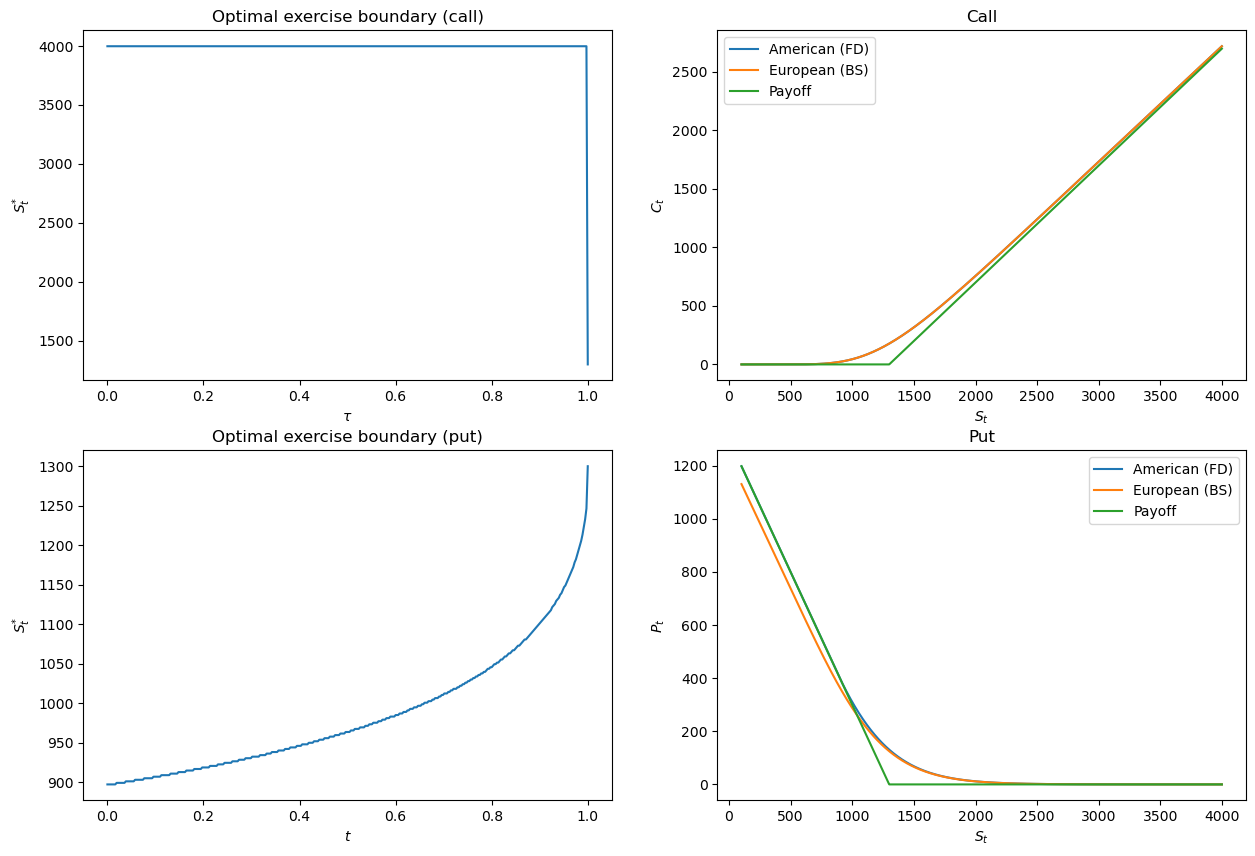

In [7]:
if type_option == 'american':
    plt.figure(figsize=(15,10))

    plt.subplot(2,2,1)
    tmp = np.sort(np.append(K, SxCall))[::-1]
    plt.plot(np.append(0,tau), tmp)
    plt.xlabel('$\\tau$')
    plt.ylabel('$S^{*}_t$')
    plt.title('Optimal exercise boundary (call)')

    plt.subplot(2,2,2)
    plt.plot(s, vCall)
    plt.plot(s, eCall)
    plt.plot(s, np.maximum(s-K, 0))
    plt.xlabel('$S_t$')
    plt.ylabel('$C_t$')
    plt.title('Call')
    plt.legend(['American (FD)', 'European (BS)', 'Payoff'])

    # calendar time as opposed to time-to-maturity
    plt.subplot(2,2,3)
    tmp = np.sort(np.append(K, SxPut))
    plt.plot(np.append(0,tau), tmp)
    plt.xlabel('$t$')
    plt.ylabel('$S^{*}_t$')
    plt.title('Optimal exercise boundary (put)')

    plt.subplot(2,2,4)
    plt.plot(s, vPut)
    plt.plot(s, ePut)
    plt.plot(s, np.maximum(K-s, 0))
    plt.xlabel('$S_t$')
    plt.ylabel('$P_t$')
    plt.title('Put')
    plt.legend(['American (FD)', 'European (BS)', 'Payoff'])
else:
    plt.figure(figsize=(15,5))
    
    plt.subplot(1,2,1)
    plt.plot(s, vCall)
    plt.plot(s, eCall)
    plt.plot(s, np.maximum(s-K, 0))
    plt.xlabel('$S_t$')
    plt.ylabel('$C_t$')
    plt.title('Call')
    plt.legend(['European (FD)', 'European (BS)', 'Payoff'])
    
    plt.subplot(1,2,2)
    plt.plot(s, vPut)
    plt.plot(s, ePut)
    plt.plot(s, np.maximum(K-s, 0))
    plt.xlabel('$S_t$')
    plt.ylabel('$P_t$')
    plt.title('Put')
    plt.legend(['European (FD)', 'European (BS)', 'Payoff'])


plt.show()
#plt.savefig('options_via_fd.pdf')